In [3]:
import espressomd
import numpy as np
#import espressomd.observables
#import espressomd.accumulators
#import espressomd.analyze
#required_features = ["LENNARD_JONES"]
#espressomd.assert_features(required_features)
#import matplotlib.pyplot as plt


In [4]:
import scipy.optimize
np.random.seed(42)

# System parameters
N_PART = 200
DENSITY = 0.75

BOX_L = np.power(N_PART / DENSITY, 1.0 / 3.0) * np.ones(3)

In [5]:
system = espressomd.System(box_l=BOX_L)
# Test solution of Exercise 1
assert isinstance(system, espressomd.System)

AttributeError: module 'espressomd' has no attribute 'System'

In [12]:
SKIN = 0.4
TIME_STEP = 0.01

system.time_step = TIME_STEP
system.cell_system.skin = SKIN

In [13]:
N_PART=200
particles = system.part.add(type=[0] * N_PART, pos=np.random.random((N_PART, 3)) * system.box_l)
# Test that now we have indeed N_PART particles in the system
assert len(system.part) == N_PART

In [14]:
# Access position of a single particle
print(f"position of particle with id 0: {system.part.by_id(0).pos}")

# Iterate over the first five particles for the purpose of demonstration.
first_five = system.part.by_ids(range(5))
for p in first_five:
    print(f"id {p.id} position: {p.pos}")
    print(f"id {p.id} velocity: {p.v}")

# Obtain particle positions for the particles created until now
cur_pos = particles.pos

position of particle with id 0: [2.41076339 6.1193638  4.7115492 ]
id 0 position: [2.41076339 6.1193638  4.7115492 ]
id 0 velocity: [0. 0. 0.]
id 1 position: [3.85332274 1.00422894 1.00407369]
id 1 velocity: [0. 0. 0.]
id 2 position: [0.37386074 5.57522583 3.86913442]
id 2 velocity: [0. 0. 0.]
id 3 position: [4.55757705 0.13249407 6.24291778]
id 3 velocity: [0. 0. 0.]
id 4 position: [5.35809689 1.36674105 1.17033384]
id 4 velocity: [0. 0. 0.]


In [17]:
# use LJ units: EPS=SIG=1
LJ_EPS = 1.0
LJ_SIG = 1.0
LJ_CUT = 2.5 * LJ_SIG
assert (BOX_L - 2 * SKIN > LJ_CUT).all()


In [18]:
system.non_bonded_inter[0, 0].lennard_jones.set_params(
    epsilon=LJ_EPS, sigma=LJ_SIG, cutoff=LJ_CUT, shift=0)

In [19]:
# suitable minimization parameters for this LJ system
F_TOL = 1e-2
DAMPING = 30
MAX_STEPS = 10000
MAX_DISPLACEMENT = 0.01 * LJ_SIG
EM_STEP = 10

# Set up steepest descent integration
system.integrator.set_steepest_descent(f_max=0,  # use a relative convergence criterion only
                                       gamma=DAMPING,
                                       max_displacement=MAX_DISPLACEMENT)

# Initialize integrator to obtain initial forces
system.integrator.run(0)
old_force = np.max(np.linalg.norm(system.part.all().f, axis=1))


while system.time / system.time_step < MAX_STEPS:
    system.integrator.run(EM_STEP)
    force = np.max(np.linalg.norm(system.part.all().f, axis=1))
    rel_force = np.abs((force - old_force) / old_force)
    print(f'rel. force change: {rel_force:.2e}')
    if rel_force < F_TOL:
        break
    old_force = force
    

rel. force change: 1.00e+00
rel. force change: 9.99e-01
rel. force change: 9.38e-01
rel. force change: 6.00e-01
rel. force change: 6.81e-01
rel. force change: 5.53e-01
rel. force change: 3.49e-01
rel. force change: 2.62e-01
rel. force change: 2.26e-03


In [20]:
# reset clock
system.time = 0.

In [22]:
# Parameters for the Langevin thermostat
# reduced temperature T* = k_B T / LJ_EPS
TEMPERATURE = 0.827  # value from Tab. 1 in [7]
GAMMA = 1.0
system.integrator.set_vv()
system.thermostat.set_langevin(kT=TEMPERATURE, gamma=GAMMA, seed=42)

# Integration parameters
STEPS_PER_SAMPLE = 20
N_SAMPLES = 1000

times = np.zeros(N_SAMPLES)
e_total = np.zeros_like(times)
e_kin = np.zeros_like(times)
T_inst = np.zeros_like(times)

In [23]:
for i in range(N_SAMPLES):
    times[i] = system.time
    energy = system.analysis.energy()
    e_total[i] = energy['total']
    e_kin[i] = energy['kinetic']
    system.integrator.run(STEPS_PER_SAMPLE)
T_inst = 2. / 3. * e_kin / N_PART

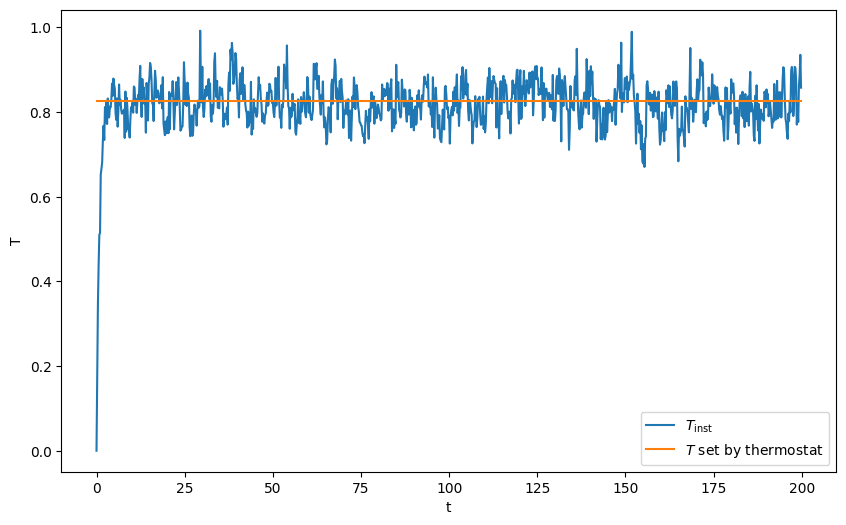

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(times, T_inst, label='$T_{\\mathrm{inst}}$')
plt.plot(times, [TEMPERATURE] * len(times), label='$T$ set by thermostat')
plt.legend()
plt.xlabel('t')
plt.ylabel('T')
plt.show()

In [28]:
# Use only the data where the system is at equilibrium
equilibration_time = 15
e_total = e_total[times > equilibration_time]
e_kin = e_kin[times > equilibration_time]
times = times[times > equilibration_time]
times -= times[0]

steps_per_subsample = 201


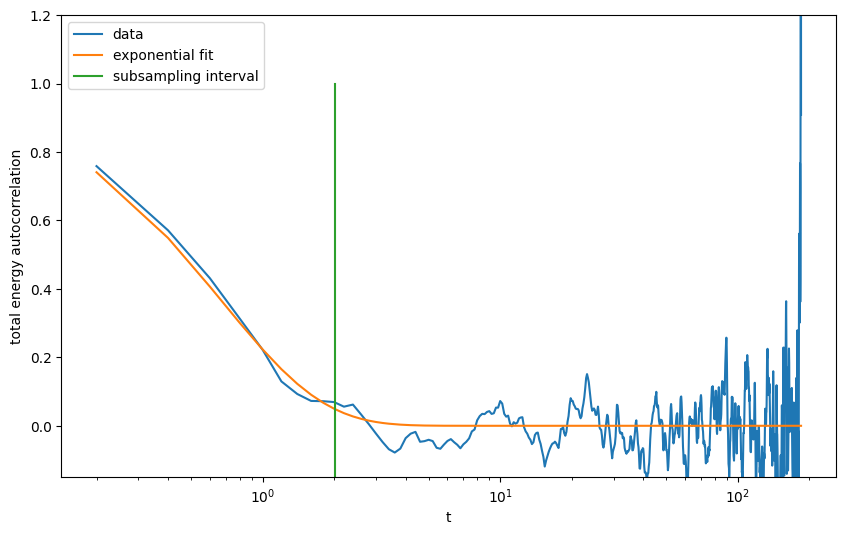

In [30]:
def autocor(x):
    x = np.asarray(x)
    mean = np.mean(x)
    var = np.var(x)
    xp = x - mean
    corr = espressomd.analyze.autocorrelation(xp) / var
    return corr


def fit_correlation_time(data, ts):
    data = np.asarray(data)
    data /= data[0]

    def fitfn(t, t_corr): return np.exp(-t / t_corr)
    popt, pcov = scipy.optimize.curve_fit(fitfn, ts, data)
    return popt[0]

e_total_autocor = autocor(e_total)
corr_time = fit_correlation_time(e_total_autocor[:100], times[:100])
steps_per_subsample = int(np.ceil(3 * corr_time / system.time_step))
print(f'steps_per_subsample = {steps_per_subsample}')

plt.figure(figsize=(10, 6))
plt.plot(times[1:], e_total_autocor[1:], label='data')
plt.plot(times[1:], np.exp(-times[1:] / corr_time), label='exponential fit')
plt.plot(2 * [steps_per_subsample * system.time_step],
         [min(e_total_autocor), 1], label='subsampling interval')
plt.ylim(top=1.2, bottom=-0.15)
plt.legend()
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('total energy autocorrelation')
plt.show()

In [31]:
subsample_step = int(np.ceil(steps_per_subsample / STEPS_PER_SAMPLE))
pot_energies = (e_total - e_kin)[::subsample_step] / N_PART
mean_pot_energy = np.mean(pot_energies)
SEM_pot_energy = np.std(pot_energies) / np.sqrt(len(pot_energies))
print(f'mean potential energy = {mean_pot_energy:.2f} +/- {SEM_pot_energy:.2f}')

mean potential energy = -4.96 +/- 0.01


In [32]:
tail_energy_per_particle = 8. / 3. * np.pi * DENSITY * LJ_EPS * \
    LJ_SIG**3 * (1. / 3. * (LJ_SIG / LJ_CUT)**9 - (LJ_SIG / LJ_CUT)**3)
mean_pot_energy_corrected = mean_pot_energy + tail_energy_per_particle
print(f'corrected mean potential energy = {mean_pot_energy_corrected:.2f}')

corrected mean potential energy = -5.36


In [34]:
# Parameters for the radial distribution function
BIN_WIDTH = 0.05
R_MIN = 0.0
R_MAX = system.box_l[0] / 2.0
N_BINS = int((R_MAX-R_MIN)/BIN_WIDTH)
rdf_obs = espressomd.observables.RDF(ids1=system.part.all().id, min_r=R_MIN, max_r=R_MAX, n_r_bins=N_BINS)
rdf_acc = espressomd.accumulators.MeanVarianceCalculator(obs=rdf_obs, delta_N=steps_per_subsample)
system.auto_update_accumulators.add(rdf_acc)

system.integrator.run(N_SAMPLES * steps_per_subsample)

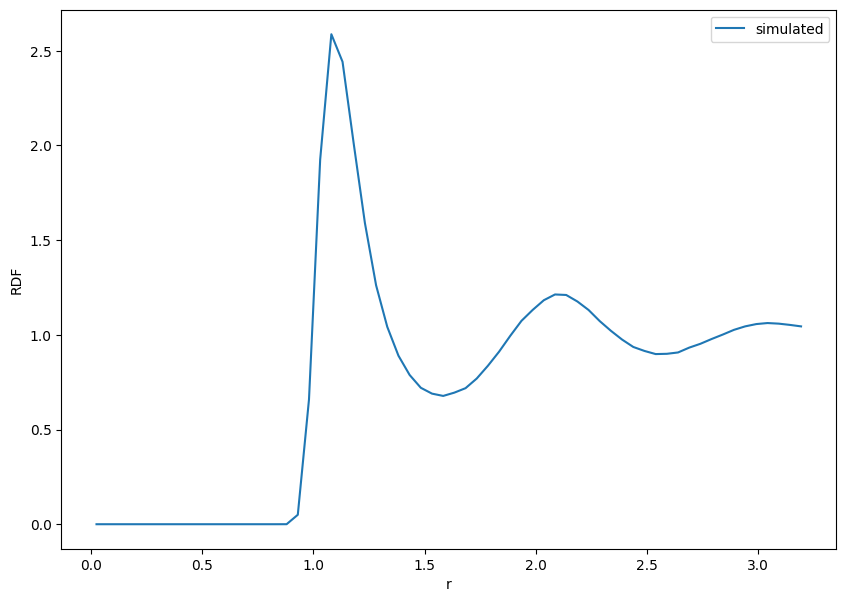

In [35]:
rdf = rdf_acc.mean()
rs = rdf_obs.bin_centers()
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(rs, rdf, label='simulated')
plt.legend()
plt.xlabel('r')
plt.ylabel('RDF')
plt.show()